# Transcriptomic profile estimation with all samples

In [14]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy import io

# Plot
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import colors as pltcolors
%matplotlib inline
plt.rcParams["font.size"] = 16

from sklearn.linear_model import LinearRegression

import sys
sys.path.append("../../scripts")
from noiseReductionMethodology import preprocessing, Raman_model
from analysis_pclda import LDA_model
from predictFunc import calcPrediction
from util import returnValues

## Load data

In [2]:
mat = io.loadmat("../../data/Matlab codes/data.mat")
RAMAN_ALL = pd.DataFrame(np.vstack([mat["ecoli_raman"][i][1][:, 1:-1] for i in range(len(mat["ecoli_raman"]))]))
RAMAN_ALL["label"] = np.hstack([[i] * len(mat["ecoli_raman"][i][1]) for i in range(len(mat["ecoli_raman"]))])
RAMAN = RAMAN_ALL.iloc[:, 1:600].copy()
RAMAN["label"] = RAMAN_ALL["label"]
RAMAN_PROCESSED = preprocessing(RAMAN)
RAMAN_PROCESSED.head()

/home/katori/anaconda3/envs/raman/lib/python3.11/site-packages/scipy/io/matlab/_mio.py:227: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,label
0,-0.976278,-0.951649,-0.974893,-1.014210,-1.014473,-1.056744,-1.062391,-1.060113,-0.982510,-0.914231,...,-1.804678,-1.766402,-1.752717,-1.741973,-1.737224,-1.719581,-1.712111,-1.728469,-1.757064,0
1,-0.919120,-0.891068,-0.866703,-0.838732,-0.800453,-0.733200,-0.664796,-0.654896,-0.688962,-0.720215,...,-1.836790,-1.847059,-1.870493,-1.884852,-1.899324,-1.897545,-1.868171,-1.823140,-1.798262,0
2,-0.629905,-0.702534,-0.770503,-0.794740,-0.698365,-0.623975,-0.546047,-0.568663,-0.590936,-0.680715,...,-1.929989,-1.921012,-1.943548,-1.958624,-1.927012,-1.890680,-1.874337,-1.897231,-1.936208,0
3,-0.656655,-0.716321,-0.739565,-0.717990,-0.677742,-0.646472,-0.635698,-0.627683,-0.606403,-0.586474,...,-1.988334,-1.981610,-1.964472,-1.971486,-1.987476,-1.988951,-1.962276,-1.940699,-1.935497,0
4,-0.879873,-0.909129,-0.925990,-0.889066,-0.782080,-0.705982,-0.670502,-0.664327,-0.632106,-0.633681,...,-2.030851,-2.019931,-1.976798,-1.927524,-1.927688,-1.934378,-1.942968,-1.954189,-1.994070,0


In [3]:
TRANSCRIPTOME = pd.DataFrame(np.mean(mat["ecoli_transcriptome"], axis=2))
TRANSCRIPTOME["label"] = range(TRANSCRIPTOME.shape[0])
TRANSCRIPTOME.head()

,0,1,2,3,4,5,6,7,8,9,...,4340,4341,4342,4343,4344,4345,4346,4347,4348,label
0,61.069861,34.995125,99.332166,75.161065,25.690889,88.629016,38.444655,3249.254173,140.488911,50.207969,...,426.835259,475.442508,30.634623,276.894518,958.871461,1564.869341,695.217458,17.804050,388.969974,0
1,153.313336,68.931578,110.365468,97.481463,45.694917,84.277861,30.268285,2011.883162,125.190809,63.653286,...,776.007289,890.196085,63.950188,229.713092,812.532973,971.069414,499.371292,20.212750,600.398443,1
2,118.789496,70.342046,106.889775,103.514263,37.024434,81.004502,31.074878,1991.197940,124.152906,69.016073,...,886.155887,1144.418418,77.484031,292.742220,907.236793,987.685581,555.964356,32.145509,691.456184,2
3,56.169045,79.575372,126.111321,117.872671,28.917155,101.562416,34.123129,2891.952372,94.939070,42.424860,...,296.076674,340.534414,13.777665,120.715299,653.097707,1161.478611,524.156753,11.650222,291.815278,3
4,49.524075,58.128314,81.701702,88.065736,16.897930,85.957944,22.551891,2755.867377,106.182925,40.708295,...,142.079672,179.233116,13.069621,151.107742,708.068624,1326.915500,694.618123,3.679118,162.344278,4


In [21]:
RAMAN.to_csv("../../data/RAMAN_FINGERPRINT_Ecoli.csv", index=None)
TRANSCRIPTOME.to_csv("../../data/TRANSCRIPTOME_Ecoli.csv", index=None)

In [4]:
clusterNum = TRANSCRIPTOME.shape[0]
colorList = ["gray", "#B51700"]
nameList = ["PCA", "NRM"]

## [Fig. S3a] Perform transcriptomic profile estimation

In [5]:
cutPercentages = np.arange(70, 100, 0.5)
cutPercentages

array([70. , 70.5, 71. , 71.5, 72. , 72.5, 73. , 73.5, 74. , 74.5, 75. ,
       75.5, 76. , 76.5, 77. , 77.5, 78. , 78.5, 79. , 79.5, 80. , 80.5,
       81. , 81.5, 82. , 82.5, 83. , 83.5, 84. , 84.5, 85. , 85.5, 86. ,
       86.5, 87. , 87.5, 88. , 88.5, 89. , 89.5, 90. , 90.5, 91. , 91.5,
       92. , 92.5, 93. , 93.5, 94. , 94.5, 95. , 95.5, 96. , 96.5, 97. ,
       97.5, 98. , 98.5, 99. , 99.5])

In [7]:
predict_list = []
percent_to_dim_PCA = []
percent_NRM = []

for cutPercent in cutPercentages:
    print(".", end="")
    raman_model = Raman_model(RAMAN_PROCESSED, cutRange=cutPercent, cutMode="percent_fixedDim")
    raman_model.calcTransformation()
    
    out = []
    for DATA in [raman_model.RAMAN_PCA, raman_model.RAMAN_NRM]:
        lda_model = LDA_model()
        DATA_LDA = lda_model.fit_transform(DATA)

        DATA_LDA = DATA_LDA.groupby("label").mean()
        DATA_LDA["label"] = np.arange(DATA_LDA.shape[0])

        PREDICT = calcPrediction(TRANSCRIPTOME, DATA_LDA, n_components=0, max_iter=50000)
        
        out.append(PREDICT)
        
    predict_list.append(out)
    percent_to_dim_PCA.append(raman_model.k_hat)
    percent_NRM.append(raman_model.percent_tilde)

print("")

............................................................


In [9]:
SUMMARY_TABLE = pd.DataFrame(columns=[f"{i:.1f}%" for i in cutPercentages]).T
SUMMARY_TABLE["dim_PCA"] = percent_to_dim_PCA
SUMMARY_TABLE["percent_NRM"] = percent_NRM

out_pca = np.array([np.sum((returnValues(data[0]) - returnValues(TRANSCRIPTOME)) ** 2, axis=1).sum()
                    for data in predict_list])

out_nrm = np.array([np.sum((returnValues(data[1]) - returnValues(TRANSCRIPTOME)) ** 2, axis=1).sum()
                    for data in predict_list])
    
pList = np.array([stats.wilcoxon(np.sum((returnValues(data[0]) - returnValues(TRANSCRIPTOME)) ** 2, axis=1),
                                 np.sum((returnValues(data[1]) - returnValues(TRANSCRIPTOME)) ** 2, axis=1),
                                 alternative="two-sided").pvalue
                  for data in predict_list])

    

SUMMARY_TABLE["PRESS_PCA"] = out_pca
SUMMARY_TABLE["PRESS_NRM"] = out_nrm
SUMMARY_TABLE["PRESS_diff"] = out_nrm - out_pca
SUMMARY_TABLE["PRESS_pVal"] = pList

out_pca_perCon = np.vstack([np.sum((returnValues(data[0]) - returnValues(TRANSCRIPTOME)) ** 2, axis=1)
                            for data in predict_list])

out_nrm_perCon = np.vstack([np.sum((returnValues(data[1]) - returnValues(TRANSCRIPTOME)) ** 2, axis=1)
                            for data in predict_list])

SUMMARY_TABLE.loc[:, [f"PRESS_PCA_c{i + 1}" for i in range(clusterNum)]] = out_pca_perCon
SUMMARY_TABLE.loc[:, [f"PRESS_NRM_c{i + 1}" for i in range(clusterNum)]] = out_nrm_perCon

SUMMARY_TABLE.head()

,dim_PCA,percent_NRM,PRESS_PCA,PRESS_NRM,PRESS_diff,PRESS_pVal,PRESS_PCA_c1,PRESS_PCA_c2,PRESS_PCA_c3,PRESS_PCA_c4,PRESS_PCA_c5,PRESS_NRM_c1,PRESS_NRM_c2,PRESS_NRM_c3,PRESS_NRM_c4,PRESS_NRM_c5
70.0%,3,73.950216,2.245454e+10,2.246660e+10,1.205319e+07,0.0625,7.183437e+09,7.335352e+09,3.440883e+09,1.841267e+09,2.653603e+09,7.190252e+09,7.335471e+09,3.441705e+09,1.844161e+09,2.655008e+09
70.5%,3,73.950216,2.245454e+10,2.246660e+10,1.205319e+07,0.0625,7.183437e+09,7.335352e+09,3.440883e+09,1.841267e+09,2.653603e+09,7.190252e+09,7.335471e+09,3.441705e+09,1.844161e+09,2.655008e+09
71.0%,3,73.950216,2.245454e+10,2.246660e+10,1.205319e+07,0.0625,7.183437e+09,7.335352e+09,3.440883e+09,1.841267e+09,2.653603e+09,7.190252e+09,7.335471e+09,3.441705e+09,1.844161e+09,2.655008e+09
71.5%,4,80.266380,1.963745e+10,1.961652e+10,-2.093132e+07,0.6250,4.810311e+09,6.642451e+09,2.822437e+09,1.901690e+09,3.460558e+09,4.809598e+09,6.646990e+09,2.829199e+09,1.890352e+09,3.440376e+09
72.0%,4,80.266380,1.963745e+10,1.961652e+10,-2.093132e+07,0.6250,4.810311e+09,6.642451e+09,2.822437e+09,1.901690e+09,3.460558e+09,4.809598e+09,6.646990e+09,2.829199e+09,1.890352e+09,3.440376e+09


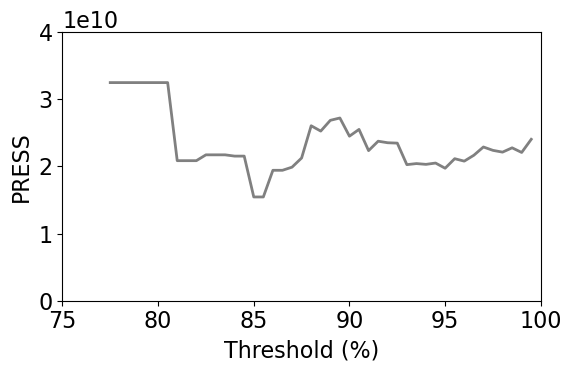

In [16]:
fig = plt.figure(figsize=(6, 4))


plt.plot(cutPercentages[SUMMARY_TABLE["dim_PCA"].values >= 5], SUMMARY_TABLE[SUMMARY_TABLE["dim_PCA"] >= 5]["PRESS_PCA"].values,
         color="gray", linewidth=2)

plt.xticks(range(75, 101, 5))
plt.xlim(75, 100)
plt.yticks(np.arange(5) * 1e10)
plt.ylim(0, 4e10)
plt.xlabel("Threshold (%)")
plt.ylabel("PRESS")
plt.tight_layout()
plt.show()

## [SFig. 3b and c] PCA- vs. NRM-advantaged elements

In [20]:
fixedPer = float(SUMMARY_TABLE.sort_values("PRESS_PCA").index[0].replace("%", ""))
fixedPer

85.0

In [7]:
raman_model = Raman_model(RAMAN_PROCESSED, cutMode="percent_fixedDim", cutRange=fixedPer)
raman_model.calcTransformation()

In [8]:
lda_model = LDA_model()
RAMAN_PCA = lda_model.fit_transform(raman_model.RAMAN_PCA)
MEAN_RAMAN_PCA = RAMAN_PCA.groupby("label").mean()
MEAN_RAMAN_PCA["label"] = np.arange(MEAN_RAMAN_PCA.shape[0])
PREDICT_PCA = calcPrediction(TRANSCRIPTOME, MEAN_RAMAN_PCA, n_components=0)

In [9]:
lda_model = LDA_model()
RAMAN_NRM = lda_model.fit_transform(raman_model.RAMAN_NRM)
MEAN_RAMAN_NRM = RAMAN_NRM.groupby("label").mean()
MEAN_RAMAN_NRM["label"] = np.arange(MEAN_RAMAN_NRM.shape[0])
PREDICT_NRM = calcPrediction(TRANSCRIPTOME, MEAN_RAMAN_NRM, n_components=0)

In [10]:
diff_pca = np.abs(returnValues(PREDICT_PCA) - returnValues(TRANSCRIPTOME))
diff_nrm = np.abs(returnValues(PREDICT_NRM) - returnValues(TRANSCRIPTOME))
error_ratio = diff_nrm / diff_pca

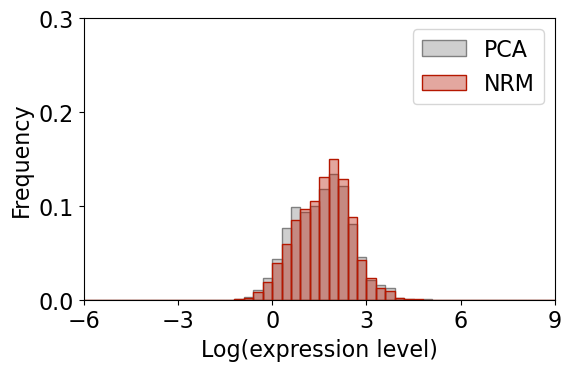

In [11]:
fig = plt.figure(figsize=(6, 4))

exp = returnValues(TRANSCRIPTOME)

pca_sup = exp[diff_pca < diff_nrm]
nrm_sup = exp[diff_pca > diff_nrm]

pca_sup = np.log10(pca_sup[pca_sup > 0])
nrm_sup = np.log10(nrm_sup[nrm_sup > 0])


for data, c, name in zip([pca_sup, nrm_sup], colorList, nameList):
    hist, bins = np.histogram(data, range=(-6, 9), bins=50)
    bins = bins[:-1] + (bins[1] - bins[0]) / 2
    plt.bar(bins, hist / hist.sum(), color=pltcolors.to_hex(c) + "60", 
            edgecolor=c, width=bins[1] - bins[0], label=name)

plt.xticks(np.arange(-6, 10, 3))
plt.xlim(-6, 9)
plt.xlabel("Log(expression level)")
plt.yticks(np.arange(0, 0.31, 0.10))
plt.ylim(0, 0.30)
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

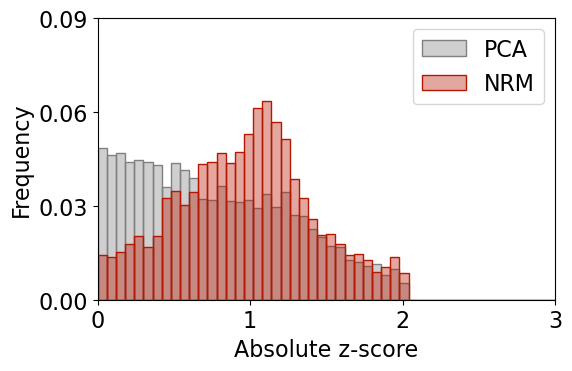

In [12]:
plt.figure(figsize=(6, 4))
exp = returnValues(TRANSCRIPTOME)
exp = np.abs(exp - np.mean(exp, axis=0)) / np.std(exp, axis=0)

pca_sup = exp[diff_pca < diff_nrm]
nrm_sup = exp[diff_pca > diff_nrm]

for data, c, name in zip([pca_sup, nrm_sup], colorList, nameList):
    hist, bins = np.histogram(data, range=(0, 3), bins=50)
    bins = bins[:-1] + (bins[1] - bins[0]) / 2
    plt.bar(bins, hist / hist.sum(), color=pltcolors.to_hex(c) + "60", 
            edgecolor=c, width=bins[1] - bins[0], label=name)

plt.xticks(np.arange(0, 4, 1))
plt.xlim(0, 3)
plt.xlabel("Absolute z-score")
plt.yticks(np.arange(0, 0.2, 0.03))
plt.ylim(0, 0.09)
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

## [SFig. 3d and e] PCA- vs. NRM-advantaged RNAs

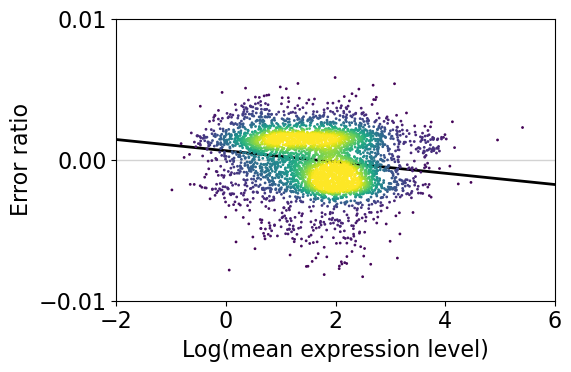

In [17]:
fig = plt.figure(figsize=(6, 4))

exp = np.mean(returnValues(TRANSCRIPTOME), axis=0)
error_ratio_mean = np.mean(diff_nrm, axis=0) / np.mean(diff_pca, axis=0)

y = np.log2(error_ratio_mean[exp > 0])
x = np.log10(exp[exp > 0])

xy = np.vstack([x, y])
z = stats.gaussian_kde(xy)(xy)
x = x[np.argsort(z)]
y = y[np.argsort(z)]
z = np.sort(z)


plt.scatter(x, y, c=z, s=1, cmap="viridis", vmax=80, vmin=0)
plt.hlines(0, -8, 8, color="lightgray", linewidth=1, zorder=0)

lr_meanExp = LinearRegression()
lr_meanExp.fit(x.reshape(-1, 1), y.reshape(-1, 1))

x_ = np.arange(-8, 9, 1)
plt.plot(x_, lr_meanExp.coef_[0][0] * x_ + lr_meanExp.intercept_, linewidth=2, color="k", zorder=0)    

plt.xticks(np.arange(-6, 7, 2))
plt.xlim(-2, 6)
plt.yticks(np.arange(-0.01, 0.02, 0.01))
plt.xlabel("Log(mean expression level)")
plt.ylabel("Error ratio")

plt.tight_layout()
plt.show()

In [19]:
coef_permutation_mean = []
trial = 0

x = np.mean(returnValues(TRANSCRIPTOME), axis=0)
y = np.mean(diff_nrm, axis=0) / np.mean(diff_pca, axis=0)

y = np.log2(y[x > 0])
x = np.log10(x[x > 0])

lr = LinearRegression()
np.random.seed(trial)

np.random.seed(0)
for i in range(int(100000)):
    if i % 10000 == 0:
        print(".", end="")
    idxList = np.arange(len(y))
    np.random.shuffle(idxList)
    lr.fit(x.reshape(-1, 1), y[idxList].reshape(-1, 1))

    coef_permutation_mean.append(lr.coef_[0][0])
    
print(f" => {((coef_permutation_mean < lr_meanExp.coef_[0][0]).sum() + 1) / (len(coef_permutation_mean) + 1):.3e}")

.......... => 1.000e-05


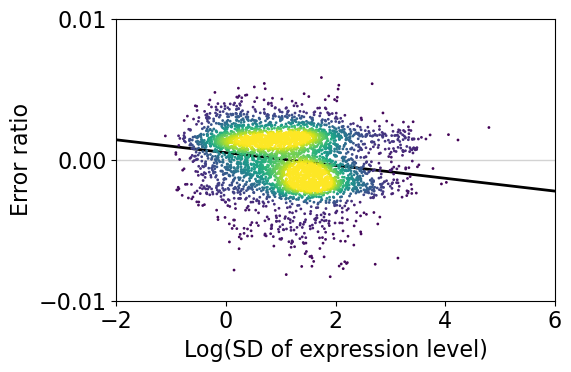

In [18]:
fig = plt.figure(figsize=(6, 4))

exp = np.std(returnValues(TRANSCRIPTOME), axis=0)
error_ratio_mean = np.mean(diff_nrm, axis=0) / np.mean(diff_pca, axis=0)

y = np.log2(error_ratio_mean[exp > 0])
x = np.log10(exp[exp > 0])

xy = np.vstack([x, y])
z = stats.gaussian_kde(xy)(xy)
x = x[np.argsort(z)]
y = y[np.argsort(z)]
z = np.sort(z)


plt.scatter(x, y, c=z, s=1, cmap="viridis", vmax=80, vmin=0)
plt.hlines(0, -8, 8, color="lightgray", linewidth=1, zorder=0)

lr_sdExp = LinearRegression()
lr_sdExp.fit(x.reshape(-1, 1), y.reshape(-1, 1))

x_ = np.arange(-8, 9, 1)
plt.plot(x_, lr_sdExp.coef_[0][0] * x_ + lr_sdExp.intercept_, linewidth=2, color="k", zorder=0)    

plt.xticks(np.arange(-6, 7, 2))
plt.xlim(-2, 6)
plt.yticks(np.arange(-0.01, 0.02, 0.01))
plt.xlabel("Log(SD of expression level)")
plt.ylabel("Error ratio")
plt.tight_layout()
plt.show()

In [20]:
coef_permutation_sd = []
trial = 0

x = np.std(returnValues(TRANSCRIPTOME), axis=0)
y = np.mean(diff_nrm, axis=0) / np.mean(diff_pca, axis=0)

y = np.log2(y[x > 0])
x = np.log10(x[x > 0])

lr = LinearRegression()
np.random.seed(trial)

np.random.seed(0)
for i in range(int(100000)):
    if i % 10000 == 0:
        print(".", end="")
    idxList = np.arange(len(y))
    np.random.shuffle(idxList)
    lr.fit(x.reshape(-1, 1), y[idxList].reshape(-1, 1))

    coef_permutation_sd.append(lr.coef_[0][0])
    
print(f" => {((coef_permutation_sd < lr_sdExp.coef_[0][0]).sum() + 1) / (len(coef_permutation_sd) + 1):.3e}")

.......... => 1.000e-05
